In [1]:
import sys
import os
sys.path.append('../../')

import data.loader

(
    (train, train_y),
    (test, test_y),
    (val, val_y),
    (one_hot_encoder_X, one_hot_encoder_y),
    (train_df, test_df, _),
    (_, _, _),
    (_, _, _)
) = data.loader.encode_and_partition(
    data.loader.diabetic_data_raw, batch_size=64, labelled=False
)

/scratch/u1319464/miniforge3/envs/diabetes/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('svc', svm.LinearSVC(verbose=True))
    ]
)
model.fit(train[:10000].toarray(), train_y[:10000].argmax(axis=-1))

/scratch/u1319464/miniforge3/envs/diabetes/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -2182.499810
nSV = 7735
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -5140.319255
nSV = 9380
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -5164.749029
nSV = 9346


/scratch/u1319464/miniforge3/envs/diabetes/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()), ('svc', LinearSVC(verbose=True))])

In [8]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

testY_proba = test_y
y_pred_proba = model.decision_function(test.toarray())

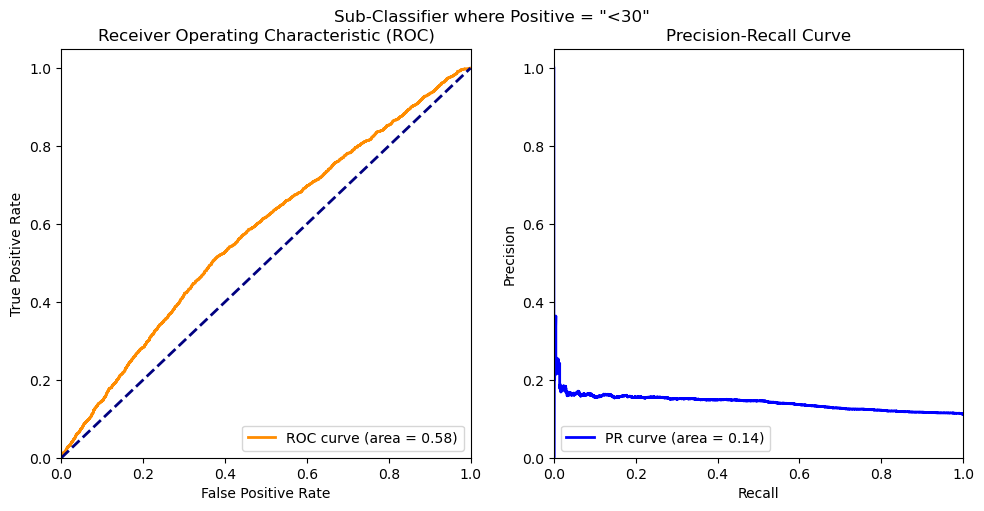

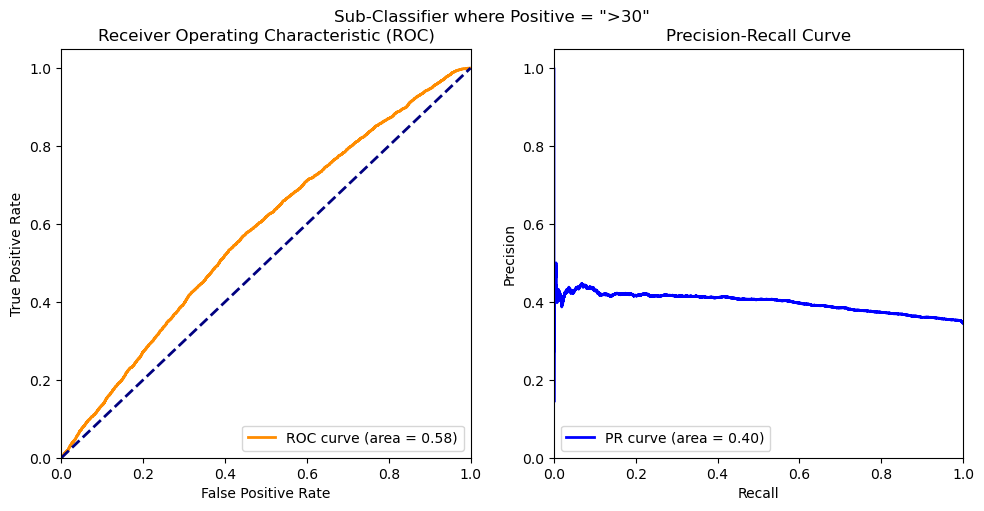

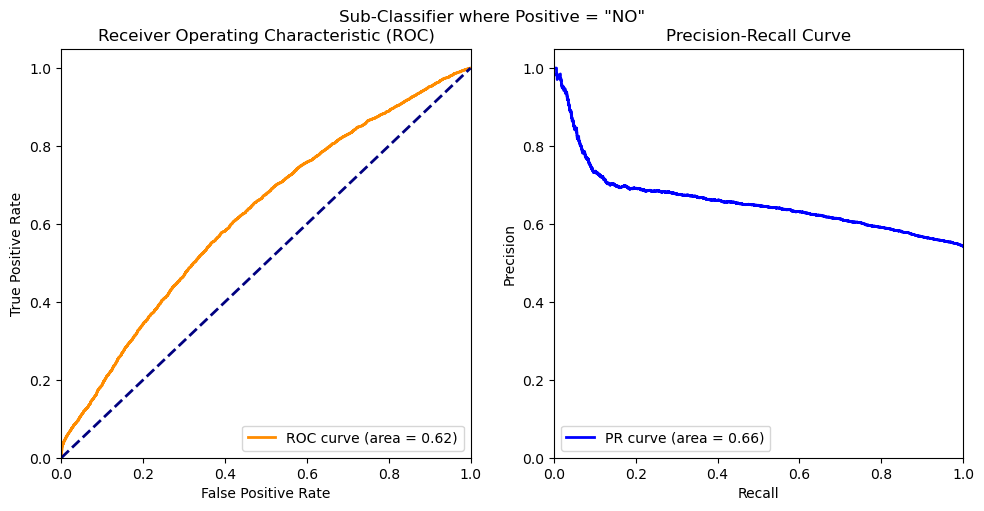

In [9]:
for i, category_value in enumerate(one_hot_encoder_y.categories_[0]):

    y_pred = y_pred_proba[:,i]
    
    testY = testY_proba[:,i]
    
    fpr, tpr, _ = roc_curve(testY, y_pred, pos_label=1)
    precision, recall, _ = precision_recall_curve(testY, y_pred)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    
    fig, (roc, prc) = plt.subplots(1, 2, figsize=(10, 5))
    
    plt.suptitle(f'Sub-Classifier where Positive = "{category_value}"')
    
    roc.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    roc.set_xlim([0.0, 1.0])
    roc.set_ylim([0.0, 1.05])
    roc.set_xlabel('False Positive Rate')
    roc.set_ylabel('True Positive Rate')
    roc.set_title('Receiver Operating Characteristic (ROC)')
    roc.set_box_aspect(1)
    roc.legend(loc="lower right")
    
    prc.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    prc.set_xlim([0.0, 1.0])
    prc.set_ylim([0.0, 1.05])
    prc.set_xlabel('Recall')
    prc.set_ylabel('Precision')
    prc.set_title('Precision-Recall Curve')
    prc.set_box_aspect(1)
    prc.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()


PermutationExplainer explainer: 11it [01:23,  9.25s/it]                                                         


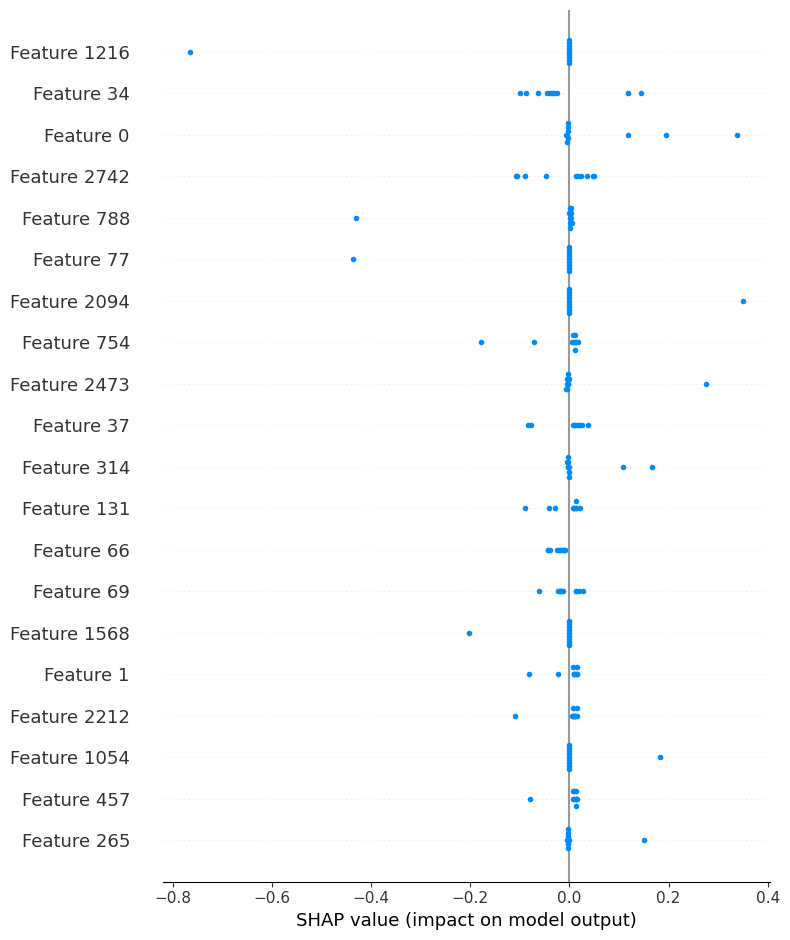

In [15]:

import shap

explainer = shap.Explainer(model.predict, train[:500].toarray())

patient_data = train.toarray()[501:511]
shap_values = explainer.shap_values(patient_data)
base_value = model.predict(patient_data).mean(axis=0)
shap.initjs()
shap.summary_plot(shap_values)



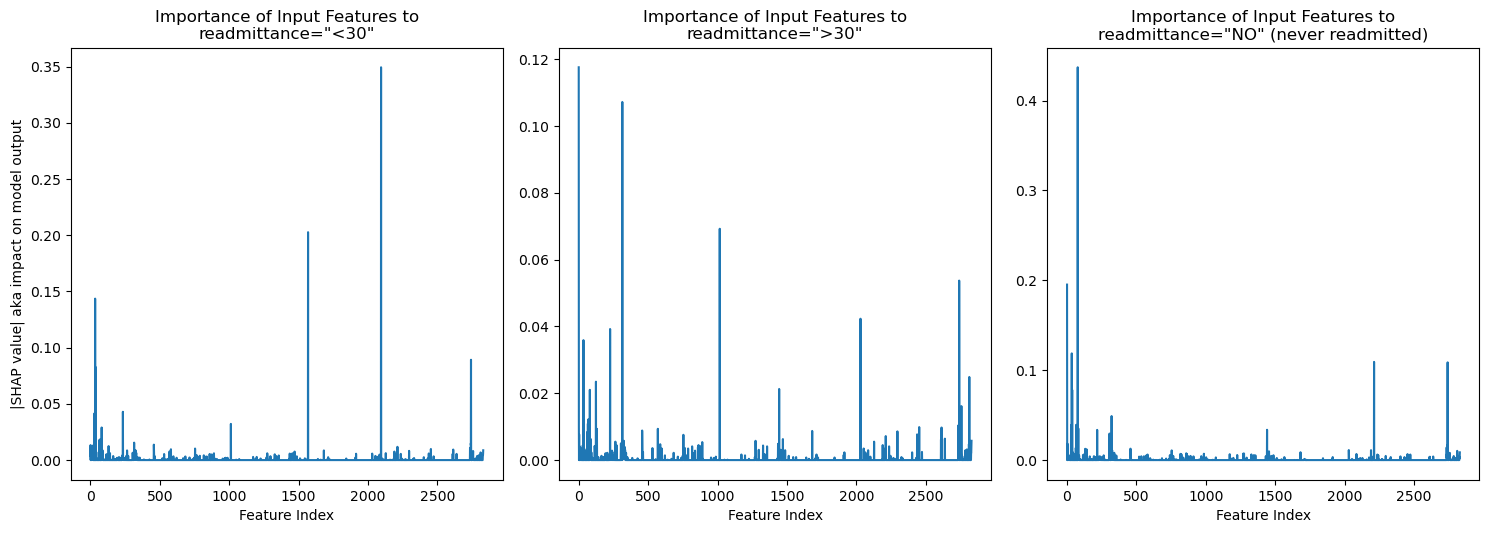

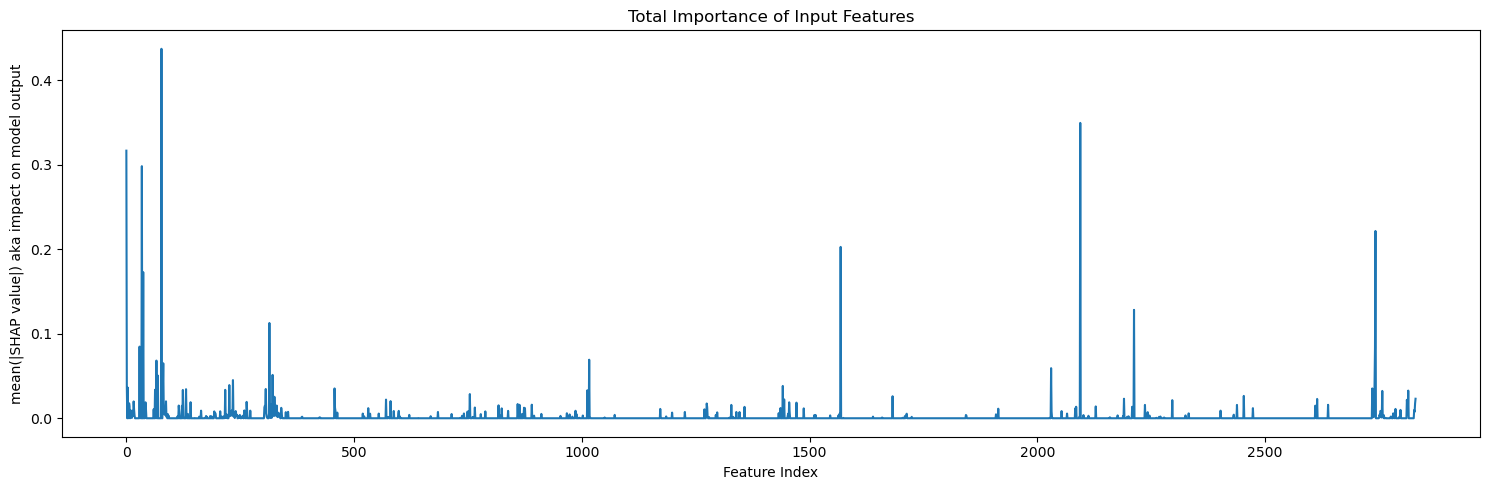

Feature Indexes Decoded. Top 15 important features shown for each classification.
readmitted="<30"
1:	acetohexamide
2:	nateglinide
3:	acarbose
4:	miglitol
5:	troglitazone
6:	tolazamide
7:	pioglitazone
8:	payer_code
9:	glipizide-metformin
10:	glimepiride-pioglitazone
11:	metformin-rosiglitazone
12:	weight
13:	metformin-pioglitazone
14:	chlorpropamide
15:	glyburide-metformin
readmitted=">30"
1:	payer_code
2:	acetohexamide
3:	chlorpropamide
4:	acarbose
5:	miglitol
6:	troglitazone
7:	tolazamide
8:	pioglitazone
9:	tolbutamide
10:	glipizide-metformin
11:	glimepiride-pioglitazone
12:	metformin-rosiglitazone
13:	weight
14:	metformin-pioglitazone
15:	nateglinide
readmitted="NO"
1:	acetohexamide
2:	nateglinide
3:	acarbose
4:	miglitol
5:	troglitazone
6:	tolazamide
7:	pioglitazone
8:	payer_code
9:	glipizide-metformin
10:	glimepiride-pioglitazone
11:	metformin-rosiglitazone
12:	weight
13:	metformin-pioglitazone
14:	chlorpropamide
15:	glyburide-metformin


In [16]:
fig, (lt30, gt30, never) = plt.subplots(1, 3, figsize=(15, 5))

lt30.set_title('Importance of Input Features to\nreadmittance="<30"')
lt30.plot(np.abs(shap_values[0]))
lt30.set_box_aspect(1)
lt30.set_ylabel('|SHAP value| aka impact on model output')
lt30.set_xlabel('Feature Index')

gt30.set_title('Importance of Input Features to\nreadmittance=">30"')
gt30.plot(np.abs(shap_values[1]))
gt30.set_box_aspect(1)
gt30.set_xlabel('Feature Index')

never.set_title('Importance of Input Features to\nreadmittance="NO" (never readmitted)')
never.plot(np.abs(shap_values[2]))
never.set_box_aspect(1)
never.set_xlabel('Feature Index')

plt.tight_layout()
plt.show()

fig, (total) = plt.subplots(1, 1, figsize=(15, 5))

total.set_title('Total Importance of Input Features')
total.plot(np.abs(shap_values[0]) + np.abs(shap_values[1]) + np.abs(shap_values[2]))
total.set_ylabel('mean(|SHAP value|) aka impact on model output')
total.set_xlabel('Feature Index')


plt.tight_layout()
plt.show()

# decode input feature indexes to their feature names
# rank by total importance assigend to all encoded indexes of that feature

print('Feature Indexes Decoded. Top 15 important features shown for each classification.')
for y_i, y_value in enumerate(one_hot_encoder_y.categories_[0]):
    i = 0
    sums = []
    importances = np.abs(shap_values[y_i])
    for cat_i, cat_name in enumerate(one_hot_encoder_X.feature_names_in_):
        cat_len = len(one_hot_encoder_X.categories_[cat_i])
        sums.append(sum(importances[i:i+cat_len]))
        i += cat_len
    print(f'readmitted="{y_value}"')
    for i, r in enumerate(one_hot_encoder_X.feature_names_in_[np.argsort(sums)][:15]):
        print(f'{i+1}:\t{r}')